In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
np.set_printoptions(suppress=True)

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
from xgboost import plot_importance

In [3]:
# import decision tree regressor and random forest regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#### Read Dataset

In [4]:
df = pd.read_csv('data/final_prepared_dataset.csv', index_col=0)

In [5]:
df.head()

,Date,total_rev,marketcap,crude_oil_price,gold_price,eur_inr,gbp_inr,usd_inr,cpi,interest_rate,gdp_growth_rate
0,2014-01-01,129298.909998,2.176082e+07,97.49,1240.3,84.524,102.996,62.680,90.659866,8.7640,1.15901
1,2014-02-01,129298.909998,1.729101e+07,102.59,1321.9,85.283,103.455,61.790,91.042397,8.8125,2.28966
2,2014-03-01,129298.909998,1.282119e+07,101.58,1284.1,82.627,99.980,60.005,91.424928,8.8375,1.82580
3,2014-04-01,142644.483000,8.351381e+06,99.74,1296.0,83.667,101.794,60.340,92.572522,8.9875,1.53396
4,2014-05-01,142644.483000,1.182611e+07,102.71,1246.3,80.662,99.127,59.180,93.337584,8.7520,1.68429


In [6]:
df.shape

(120, 11)

In [7]:
df.head()

,Date,total_rev,marketcap,crude_oil_price,gold_price,eur_inr,gbp_inr,usd_inr,cpi,interest_rate,gdp_growth_rate
0,2014-01-01,129298.909998,2.176082e+07,97.49,1240.3,84.524,102.996,62.680,90.659866,8.7640,1.15901
1,2014-02-01,129298.909998,1.729101e+07,102.59,1321.9,85.283,103.455,61.790,91.042397,8.8125,2.28966
2,2014-03-01,129298.909998,1.282119e+07,101.58,1284.1,82.627,99.980,60.005,91.424928,8.8375,1.82580
3,2014-04-01,142644.483000,8.351381e+06,99.74,1296.0,83.667,101.794,60.340,92.572522,8.9875,1.53396
4,2014-05-01,142644.483000,1.182611e+07,102.71,1246.3,80.662,99.127,59.180,93.337584,8.7520,1.68429


### Feature Engineering

##### Checking for any null in revenues

In [8]:
df[df['total_rev'].isnull()].sum()

Date                 0
total_rev          0.0
marketcap          0.0
crude_oil_price    0.0
gold_price         0.0
eur_inr            0.0
gbp_inr            0.0
usd_inr            0.0
cpi                0.0
interest_rate      0.0
gdp_growth_rate    0.0
dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 119
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             120 non-null    object 
 1   total_rev        120 non-null    float64
 2   marketcap        120 non-null    float64
 3   crude_oil_price  120 non-null    float64
 4   gold_price       120 non-null    float64
 5   eur_inr          120 non-null    float64
 6   gbp_inr          120 non-null    float64
 7   usd_inr          120 non-null    float64
 8   cpi              120 non-null    float64
 9   interest_rate    120 non-null    float64
 10  gdp_growth_rate  120 non-null    float64
dtypes: float64(10), object(1)
memory usage: 11.2+ KB


#### Moving Averages

We'll calculate the 3-month and 6-month moving averages for the 'total_rev' column

In [10]:
df = df.sort_values(by=['Date'],ascending=True).reset_index(drop=True)
df

,Date,total_rev,marketcap,crude_oil_price,gold_price,eur_inr,gbp_inr,usd_inr,cpi,interest_rate,gdp_growth_rate
0,2014-01-01,129298.909998,2.176082e+07,97.49,1240.3,84.524,102.996,62.680,90.659866,8.7640,1.15901
1,2014-02-01,129298.909998,1.729101e+07,102.59,1321.9,85.283,103.455,61.790,91.042397,8.8125,2.28966
2,2014-03-01,129298.909998,1.282119e+07,101.58,1284.1,82.627,99.980,60.005,91.424928,8.8375,1.82580
3,2014-04-01,142644.483000,8.351381e+06,99.74,1296.0,83.667,101.794,60.340,92.572522,8.9875,1.53396
4,2014-05-01,142644.483000,1.182611e+07,102.71,1246.3,80.662,99.127,59.180,93.337584,8.7520,1.68429
...,...,...,...,...,...,...,...,...,...,...,...
115,2023-08-01,294215.265000,1.884612e+07,83.63,1965.9,89.657,104.808,82.702,153.364995,7.1900,13.10964
116,2023-09-01,294215.265000,2.330638e+07,90.79,1885.4,87.763,101.272,83.030,151.492003,7.1700,5.50065
117,2023-10-01,294574.047000,1.861953e+07,81.02,1994.3,88.052,101.173,83.256,152.483587,7.3500,4.63684
118,2023-11-01,294574.047000,1.949920e+07,75.96,2038.1,90.734,105.213,83.357,153.254819,7.2700,6.28800


In [11]:
# Calculate the moving averages - 3 months & 6 months
df['3_month_MA'] = df['total_rev'].rolling(window=3).mean().reset_index(drop=True)
df['6_month_MA'] = df['total_rev'].rolling(window=6).mean().reset_index(drop=True)


In [12]:
df.head(10)

,Date,total_rev,marketcap,crude_oil_price,gold_price,eur_inr,gbp_inr,usd_inr,cpi,interest_rate,gdp_growth_rate,3_month_MA,6_month_MA
0,2014-01-01,129298.909998,2.176082e+07,97.49,1240.3,84.524,102.996,62.680,90.659866,8.7640,1.15901,NaN,NaN
1,2014-02-01,129298.909998,1.729101e+07,102.59,1321.9,85.283,103.455,61.790,91.042397,8.8125,2.28966,NaN,NaN
2,2014-03-01,129298.909998,1.282119e+07,101.58,1284.1,82.627,99.980,60.005,91.424928,8.8375,1.82580,129298.909998,NaN
3,2014-04-01,142644.483000,8.351381e+06,99.74,1296.0,83.667,101.794,60.340,92.572522,8.9875,1.53396,133747.434332,NaN
4,2014-05-01,142644.483000,1.182611e+07,102.71,1246.3,80.662,99.127,59.180,93.337584,8.7520,1.68429,138195.958666,NaN
5,2014-06-01,142644.483000,1.046056e+07,105.37,1322.4,82.208,102.695,60.045,94.102646,8.6325,2.14175,142644.483000,135971.696499
6,2014-07-01,143100.339000,1.058644e+07,98.17,1282.8,81.064,102.233,60.550,96.397832,8.6550,1.84622,142796.435000,138271.934666
7,2014-08-01,143100.339000,1.215308e+07,95.96,1287.4,79.455,100.420,60.505,96.780363,8.5600,2.03253,142948.387000,140572.172833
8,2014-09-01,143100.339000,1.105823e+07,91.16,1212.3,78.217,100.393,61.925,96.780363,8.4925,2.90241,143100.339000,142872.411000
9,2014-10-01,147929.818210,1.073733e+07,80.54,1172.4,76.885,98.193,61.390,96.780363,8.4020,1.78091,144710.165403,143753.300202


#### Bollinger Bands

Bollinger Bands consist of a middle band being the moving average (MA) and two outer bands at a distance of 2 standard deviations away from the MA

In [13]:
# Calculate the standard deviations
df['3_month_std'] = df['total_rev'].rolling(window=3).std()
df['6_month_std'] = df['total_rev'].rolling(window=6).std()

# Calculate the Bollinger Bands
df['3_month_upper_band'] = df['3_month_MA'] + (df['3_month_std'] * 2)
df['3_month_lower_band'] = df['3_month_MA'] - (df['3_month_std'] * 2)
df['6_month_upper_band'] = df['6_month_MA'] + (df['6_month_std'] * 2)
df['6_month_lower_band'] = df['6_month_MA'] - (df['6_month_std'] * 2)

In [14]:
df.head(10)

,Date,total_rev,marketcap,crude_oil_price,gold_price,eur_inr,gbp_inr,usd_inr,cpi,interest_rate,gdp_growth_rate,3_month_MA,6_month_MA,3_month_std,6_month_std,3_month_upper_band,3_month_lower_band,6_month_upper_band,6_month_lower_band
0,2014-01-01,129298.909998,2.176082e+07,97.49,1240.3,84.524,102.996,62.680,90.659866,8.7640,1.15901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-02-01,129298.909998,1.729101e+07,102.59,1321.9,85.283,103.455,61.790,91.042397,8.8125,2.28966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-03-01,129298.909998,1.282119e+07,101.58,1284.1,82.627,99.980,60.005,91.424928,8.8375,1.82580,129298.909998,NaN,0.000000,NaN,129298.909998,129298.909998,NaN,NaN
3,2014-04-01,142644.483000,8.351381e+06,99.74,1296.0,83.667,101.794,60.340,92.572522,8.9875,1.53396,133747.434332,NaN,7705.070165,NaN,149157.574662,118337.294002,NaN,NaN
4,2014-05-01,142644.483000,1.182611e+07,102.71,1246.3,80.662,99.127,59.180,93.337584,8.7520,1.68429,138195.958666,NaN,7705.070165,NaN,153606.098996,122785.818336,NaN,NaN
5,2014-06-01,142644.483000,1.046056e+07,105.37,1322.4,82.208,102.695,60.045,94.102646,8.6325,2.14175,142644.483000,135971.696499,0.000000,7309.671376,142644.483000,142644.483000,150591.039251,121352.353747
6,2014-07-01,143100.339000,1.058644e+07,98.17,1282.8,81.064,102.233,60.550,96.397832,8.6550,1.84622,142796.435000,138271.934666,263.188584,6952.717003,143322.812169,142270.057831,152177.368671,124366.500661
7,2014-08-01,143100.339000,1.215308e+07,95.96,1287.4,79.455,100.420,60.505,96.780363,8.5600,2.03253,142948.387000,140572.172833,263.188584,5527.261737,143474.764169,142422.009831,151626.696308,129517.649359
8,2014-09-01,143100.339000,1.105823e+07,91.16,1212.3,78.217,100.393,61.925,96.780363,8.4925,2.90241,143100.339000,142872.411000,0.000000,249.682614,143100.339000,143100.339000,143371.776228,142373.045772
9,2014-10-01,147929.818210,1.073733e+07,80.54,1172.4,76.885,98.193,61.390,96.780363,8.4020,1.78091,144710.165403,143753.300202,2788.301122,2058.219077,150286.767647,139133.563159,147869.738355,139636.862048


#### Lag Features

In [15]:
# Generating lag features
df['lag_1'] = df['total_rev'].shift(1)
df['lag_2'] = df['total_rev'].shift(2)
df['lag_3'] = df['total_rev'].shift(3)
df['lag_4'] = df['total_rev'].shift(4)
df['lag_5'] = df['total_rev'].shift(5)
df['lag_6'] = df['total_rev'].shift(6)

In [16]:
# # target variables for next 6 months
df['target_1'] = df['total_rev'].shift(-1)
df['target_2'] = df['total_rev'].shift(-2)
df['target_3'] = df['total_rev'].shift(-3)
df['target_4'] = df['total_rev'].shift(-4)
df['target_5'] = df['total_rev'].shift(-5)
df['target_6'] = df['total_rev'].shift(-6)

In [17]:
df

,Date,total_rev,marketcap,crude_oil_price,gold_price,eur_inr,gbp_inr,usd_inr,cpi,interest_rate,...,lag_3,lag_4,lag_5,lag_6,target_1,target_2,target_3,target_4,target_5,target_6
0,2014-01-01,129298.909998,2.176082e+07,97.49,1240.3,84.524,102.996,62.680,90.659866,8.7640,...,NaN,NaN,NaN,NaN,129298.909998,129298.909998,142644.483,142644.483,142644.48300,143100.33900
1,2014-02-01,129298.909998,1.729101e+07,102.59,1321.9,85.283,103.455,61.790,91.042397,8.8125,...,NaN,NaN,NaN,NaN,129298.909998,142644.483000,142644.483,142644.483,143100.33900,143100.33900
2,2014-03-01,129298.909998,1.282119e+07,101.58,1284.1,82.627,99.980,60.005,91.424928,8.8375,...,NaN,NaN,NaN,NaN,142644.483000,142644.483000,142644.483,143100.339,143100.33900,143100.33900
3,2014-04-01,142644.483000,8.351381e+06,99.74,1296.0,83.667,101.794,60.340,92.572522,8.9875,...,129298.909998,NaN,NaN,NaN,142644.483000,142644.483000,143100.339,143100.339,143100.33900,147929.81821
4,2014-05-01,142644.483000,1.182611e+07,102.71,1246.3,80.662,99.127,59.180,93.337584,8.7520,...,129298.909998,129298.909998,NaN,NaN,142644.483000,143100.339000,143100.339,143100.339,147929.81821,147929.81821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-08-01,294215.265000,1.884612e+07,83.63,1965.9,89.657,104.808,82.702,153.364995,7.1900,...,277804.874000,277804.874000,272154.839,272154.839,294215.265000,294574.047000,294574.047,294574.047,NaN,NaN
116,2023-09-01,294215.265000,2.330638e+07,90.79,1885.4,87.763,101.272,83.030,151.492003,7.1700,...,277804.874000,277804.874000,277804.874,272154.839,294574.047000,294574.047000,294574.047,NaN,NaN,NaN
117,2023-10-01,294574.047000,1.861953e+07,81.02,1994.3,88.052,101.173,83.256,152.483587,7.3500,...,294215.265000,277804.874000,277804.874,277804.874,294574.047000,294574.047000,NaN,NaN,NaN,NaN
118,2023-11-01,294574.047000,1.949920e+07,75.96,2038.1,90.734,105.213,83.357,153.254819,7.2700,...,294215.265000,294215.265000,277804.874,277804.874,294574.047000,NaN,NaN,NaN,NaN,NaN


#### Correlation

<Axes: >

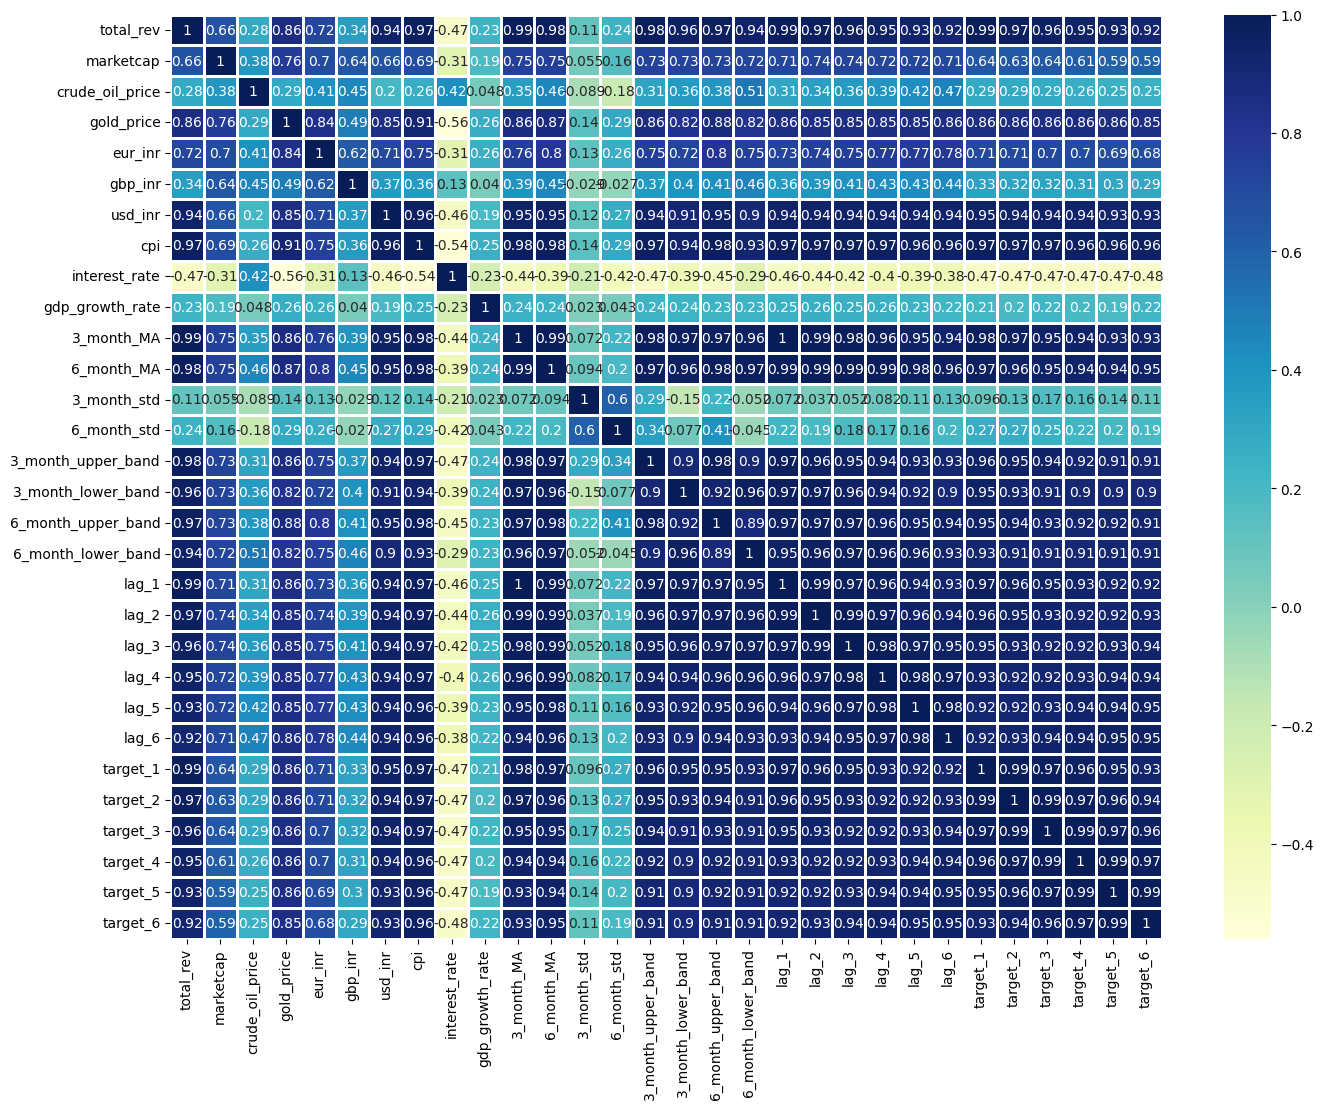

In [19]:
# plotting the correlation in a heatmap
# without date column
corr_df = df.copy()
corr_df = corr_df.drop(['Date'], axis=1)
plt.figure(figsize=(16,12))
sns.heatmap(corr_df.corr(),annot=True,cmap='YlGnBu',linewidths=1)

In [20]:
df.columns

Index(['Date', 'total_rev', 'marketcap', 'crude_oil_price', 'gold_price',
       'eur_inr', 'gbp_inr', 'usd_inr', 'cpi', 'interest_rate',
       'gdp_growth_rate', '3_month_MA', '6_month_MA', '3_month_std',
       '6_month_std', '3_month_upper_band', '3_month_lower_band',
       '6_month_upper_band', '6_month_lower_band', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'target_1', 'target_2', 'target_3',
       'target_4', 'target_5', 'target_6'],
      dtype='object')

In [21]:
df.shape

(120, 31)

#### Data Splitting & Modelling

In [22]:
X = df.copy()

In [23]:
X.columns

Index(['Date', 'total_rev', 'marketcap', 'crude_oil_price', 'gold_price',
       'eur_inr', 'gbp_inr', 'usd_inr', 'cpi', 'interest_rate',
       'gdp_growth_rate', '3_month_MA', '6_month_MA', '3_month_std',
       '6_month_std', '3_month_upper_band', '3_month_lower_band',
       '6_month_upper_band', '6_month_lower_band', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'target_1', 'target_2', 'target_3',
       'target_4', 'target_5', 'target_6'],
      dtype='object')

In [24]:
# prepare the data for modeling
X = X.dropna(subset=['target_1', 'target_2', 'target_3', 'target_4', 'target_5', 'target_6'])

In [25]:
non_features = ['Date', '3_month_std', '6_month_std']

# only selected features
X = X.drop(non_features, axis=1)

# # remove null value records
X.dropna(inplace=True)

In [26]:
# target
y = X.loc[:,['target_1', 'target_2', 'target_3', 'target_4', 'target_5', 'target_6']]

# features final
X = X.drop(['target_1', 'target_2', 'target_3', 'target_4', 'target_5', 'target_6'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train Set- X_train:{}, y_train:{}:'.format(X_train.shape, X_test.shape))
print('Test Set- X_test:{}, y_test:{}:'.format(y_train.shape, y_test.shape))

# to find the x-features columns
print(X_train.columns)
#     x_variables = X_train.columns

# Scaling features
#-----------------
# Standard Scaler
sc = StandardScaler()

# for scaled train data
X_train_scaled = sc.fit_transform(X_train)

# for scaled test data
X_test_scaled = sc.transform(X_test)

Train Set- X_train:(86, 22), y_train:(22, 22):
Test Set- X_test:(86, 6), y_test:(22, 6):
Index(['total_rev', 'marketcap', 'crude_oil_price', 'gold_price', 'eur_inr',
       'gbp_inr', 'usd_inr', 'cpi', 'interest_rate', 'gdp_growth_rate',
       '3_month_MA', '6_month_MA', '3_month_upper_band', '3_month_lower_band',
       '6_month_upper_band', '6_month_lower_band', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6'],
      dtype='object')


#### Model Fitting

#### Ridge Regression

In [28]:
# Ridge Regression

params = {'alpha': (np.arange(0.0, 100, 0.1))}
ridge = Ridge()
ridge_model = GridSearchCV(ridge, params, cv = 10)
ridge_model.fit(X_train_scaled, y_train)
print('Best params:', ridge_model.best_params_)
print('Best score:',ridge_model.best_score_)

Best params: {'alpha': 0.1}
Best score: 0.9155667503477742


In [29]:
# Model fitting
#--------------
ridge_reg = Ridge(alpha=0.1, fit_intercept=True)
ridge_reg.fit(X_train_scaled,y_train)

# Testing
#--------
y_test_pred = ridge_reg.predict(X_test_scaled)
mse_test = mean_squared_error(y_test,y_test_pred)
rmse_test = np.sqrt(mse_test)
R2_score_test = r2_score(y_test,y_test_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)
print("RMSE:", rmse_test)
print("R2 Score:", R2_score_test)
print("MAPE :", MAPE_test)

RMSE: 10486.04586985001
R2 Score: 0.9186535174739708
MAPE : 0.040633260159683875


##### Linear Regression

In [34]:
# Linear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Testing
#--------
y_test_pred = lin_reg.predict(X_test_scaled)
mse_test = mean_squared_error(y_test,y_test_pred)
rmse_test = np.sqrt(mse_test)
R2_score_test = r2_score(y_test,y_test_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)
print("RMSE:", rmse_test)
print("R2 Score:", R2_score_test)
print("MAPE :", MAPE_test)

RMSE: 10762.182971074713
R2 Score: 0.9142312637624626
MAPE : 0.041505910331116565


##### Lasso Regression

In [32]:
# Lasso Regression

# Using GridSearchCV to find the best alpha
params = {'alpha': np.arange(0.01, 1.0, 0.05)}
lasso = Lasso()
lasso_model = GridSearchCV(lasso, params, cv = 10)
lasso_model.fit(X_train_scaled, y_train)
print('Best params:', lasso_model.best_params_)
print('Best score:',lasso_model.best_score_)


/Users/amilaviraj/anaconda3/envs/vis_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.517e+08, tolerance: 1.117e+07
  model = cd_fast.enet_coordinate_descent(
/Users/amilaviraj/anaconda3/envs/vis_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.630e+08, tolerance: 1.149e+07
  model = cd_fast.enet_coordinate_descent(
/Users/amilaviraj/anaconda3/envs/vis_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

Best params: {'alpha': 0.7100000000000001}
Best score: 0.9156954533324203


/Users/amilaviraj/anaconda3/envs/vis_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.866e+07, tolerance: 1.324e+07
  model = cd_fast.enet_coordinate_descent(
/Users/amilaviraj/anaconda3/envs/vis_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.945e+07, tolerance: 1.363e+07
  model = cd_fast.enet_coordinate_descent(
/Users/amilaviraj/anaconda3/envs/vis_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

In [33]:
# Model fitting
#--------------
lasso_reg = Lasso(alpha=0.71)
lasso_reg.fit(X_train_scaled,y_train)

# Testing
#--------
y_test_pred = lasso_reg.predict(X_test_scaled)
mse_test = mean_squared_error(y_test,y_test_pred)
rmse_test = np.sqrt(mse_test)
R2_score_test = r2_score(y_test,y_test_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)
print("RMSE:", rmse_test)
print("R2 Score:", R2_score_test)
print("MAPE :", MAPE_test)

RMSE: 10737.515568364284
R2 Score: 0.9146299758764997
MAPE : 0.041427645436191714


/Users/amilaviraj/anaconda3/envs/vis_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e+07, tolerance: 1.293e+07
  model = cd_fast.enet_coordinate_descent(
/Users/amilaviraj/anaconda3/envs/vis_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.866e+07, tolerance: 1.324e+07
  model = cd_fast.enet_coordinate_descent(
/Users/amilaviraj/anaconda3/envs/vis_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

##### Decision Tree Regressor

In [35]:
# Decision Tree Regressor

# Using GridSearchCV to find the best max_depth
params = {'max_depth': np.arange(1, 10)}
dt = DecisionTreeRegressor()
dt_model = GridSearchCV(dt, params, cv = 10)
dt_model.fit(X_train_scaled, y_train)
print('Best params:', dt_model.best_params_)
print('Best score:',dt_model.best_score_)

Best params: {'max_depth': 9}
Best score: 0.825680925614089


In [36]:
# Model fitting
#--------------
dt_reg = DecisionTreeRegressor(max_depth=9)
dt_reg.fit(X_train_scaled,y_train)

# Testing
#--------
y_test_pred = dt_reg.predict(X_test_scaled)
mse_test = mean_squared_error(y_test,y_test_pred)
rmse_test = np.sqrt(mse_test)
R2_score_test = r2_score(y_test,y_test_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)
print("RMSE:", rmse_test)
print("R2 Score:", R2_score_test)
print("MAPE :", MAPE_test)

RMSE: 11598.948213033316
R2 Score: 0.9016373004581366
MAPE : 0.032631532448699985


##### Random Forest Regressor

In [37]:
# Random Forest Regressor

# Using GridSearchCV to find the best max_depth
params = {'max_depth': np.arange(1, 10), 'n_estimators': np.arange(1, 100)}
rf = RandomForestRegressor()
rf_model = GridSearchCV(rf, params, cv = 10)
rf_model.fit(X_train_scaled, y_train)
print('Best params:', rf_model.best_params_)
print('Best score:',rf_model.best_score_)


Best params: {'max_depth': 7, 'n_estimators': 67}
Best score: 0.9275417732120053


In [38]:
# Model fitting
#--------------
rf_reg = RandomForestRegressor(max_depth=7, n_estimators=67)
rf_reg.fit(X_train_scaled,y_train)

# Testing
#--------
y_test_pred = rf_reg.predict(X_test_scaled)
mse_test = mean_squared_error(y_test,y_test_pred)
rmse_test = np.sqrt(mse_test)
R2_score_test = r2_score(y_test,y_test_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)
print("RMSE:", rmse_test)
print("R2 Score:", R2_score_test)
print("MAPE :", MAPE_test)

RMSE: 7976.052796401991
R2 Score: 0.9533183818904233
MAPE : 0.02935068073102187


In [39]:
# XGBoost Regressor

# Using GridSearchCV to find the best max_depth
params = {'max_depth': np.arange(1, 10), 'n_estimators': np.arange(1, 100)}
xgb = XGBRegressor()
xgb_model = GridSearchCV(xgb, params, cv = 10)
xgb_model.fit(X_train_scaled, y_train)
print('Best params:', xgb_model.best_params_)
print('Best score:',xgb_model.best_score_)

Best params: {'max_depth': 2, 'n_estimators': 52}
Best score: 0.9219668224258163


In [40]:
# Model fitting
#--------------
xgb_reg = XGBRegressor(max_depth=2, n_estimators=52)
xgb_reg.fit(X_train_scaled,y_train)

# Testing
#--------
y_test_pred = xgb_reg.predict(X_test_scaled)
mse_test = mean_squared_error(y_test,y_test_pred)
rmse_test = np.sqrt(mse_test)
R2_score_test = r2_score(y_test,y_test_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)
print("RMSE:", rmse_test)
print("R2 Score:", R2_score_test)
print("MAPE :", MAPE_test)

RMSE: 8308.485244877087
R2 Score: 0.9493238890859433
MAPE : 0.02719690571961424


#### Model Comparisons

/var/folders/sb/f47mxfbj0wzd8zt7cp8zbtnr0000gn/T/ipykernel_79173/347355518.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Value', data=df[df['Metric'] == metric], ax=ax, palette="Blues", width=0.5)
/var/folders/sb/f47mxfbj0wzd8zt7cp8zbtnr0000gn/T/ipykernel_79173/347355518.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/var/folders/sb/f47mxfbj0wzd8zt7cp8zbtnr0000gn/T/ipykernel_79173/347355518.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Value', data=df[df['Metric'] == metric], ax=ax, palette="Blues", width=0

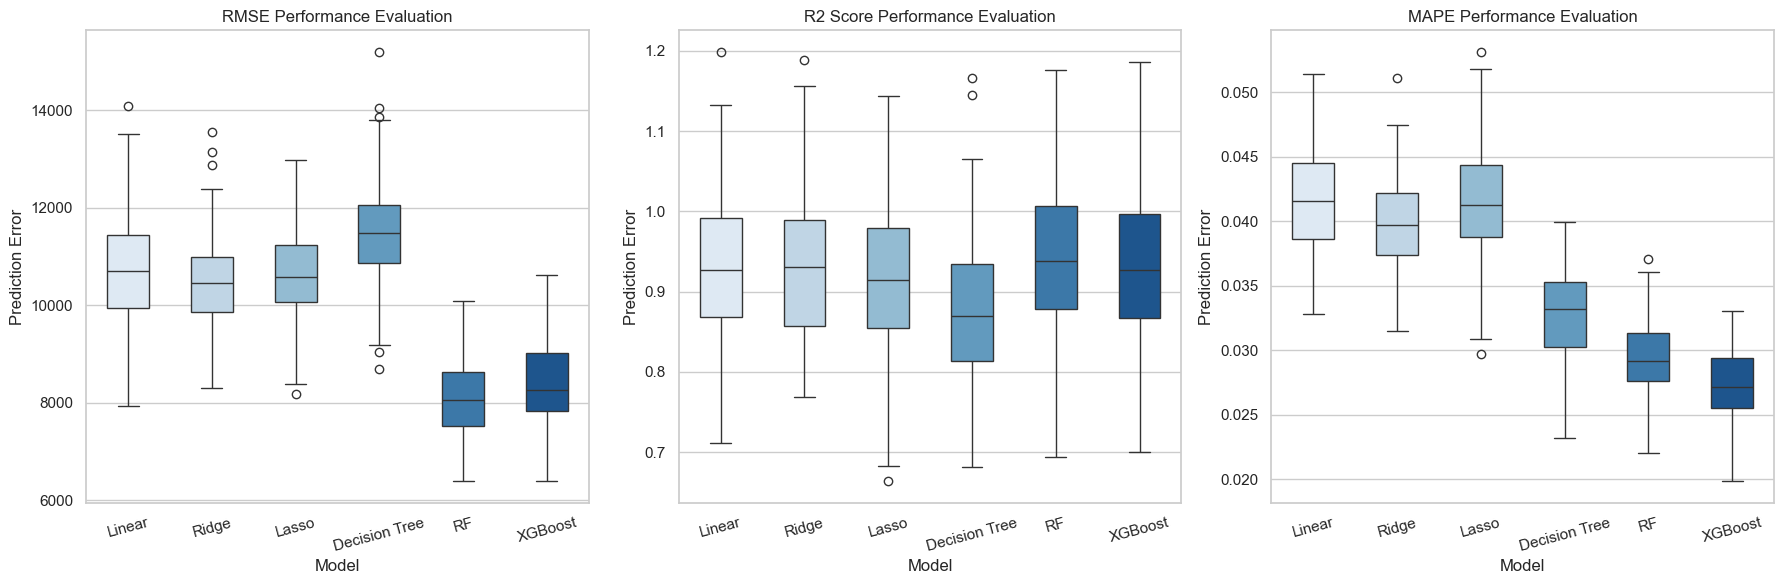

In [52]:
models = ['Linear', 'Ridge', 'Lasso', 'Decision Tree', 'RF', 'XGBoost']

# Use the provided evaluation metrics to generate synthetic data
metrics = {
    'Linear': {'RMSE': 10762.182971074713, 'R2 Score': 0.9142312637624626, 'MAPE': 0.041505910331116565},
    'Ridge': {'RMSE': 10486.04586985001, 'R2 Score': 0.9186535174739708, 'MAPE': 0.040633260159683875},
    'Lasso': {'RMSE': 10737.515568364284, 'R2 Score': 0.9146299758764997, 'MAPE': 0.041427645436191714},
    'Decision Tree': {'RMSE': 11598.948213033316, 'R2 Score': 0.9016373004581366, 'MAPE': 0.032631532448699985},
    'RF': {'RMSE': 7976.052796401991, 'R2 Score': 0.9533183818904233, 'MAPE': 0.02935068073102187},
    'XGBoost': {'RMSE': 8308.485244877087, 'R2 Score': 0.9493238890859433, 'MAPE': 0.02719690571961424}
}

# Create a DataFrame to store the synthetic data
data = {'Model': [], 'Metric': [], 'Value': []}

for model, values in metrics.items():
    for metric, mean_value in values.items():
        # Generate synthetic data with some variation
        synthetic_data = np.random.normal(loc=mean_value, scale=mean_value*0.1, size=100)
        data['Model'].extend([model] * len(synthetic_data))
        data['Metric'].extend([metric] * len(synthetic_data))
        data['Value'].extend(synthetic_data)

df = pd.DataFrame(data)

# Set the style of the visualization
sns.set(style="whitegrid")

# Create the boxplots for each metric
metrics_list = ['RMSE', 'R2 Score', 'MAPE']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for ax, metric in zip(axes, metrics_list):
    sns.boxplot(x='Model', y='Value', data=df[df['Metric'] == metric], ax=ax, palette="Blues", width=0.5)
    ax.set_title(f'{metric} Performance Evaluation')
    ax.set_ylabel('Prediction Error')
    ax.set_xlabel('Model')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

plt.tight_layout()
plt.show()


/var/folders/sb/f47mxfbj0wzd8zt7cp8zbtnr0000gn/T/ipykernel_79173/1354724150.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Value', data=df[df['Metric'] == 'RMSE'], ax=axes[0, 0], palette="Blues", width=0.5)
/var/folders/sb/f47mxfbj0wzd8zt7cp8zbtnr0000gn/T/ipykernel_79173/1354724150.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=15)
/var/folders/sb/f47mxfbj0wzd8zt7cp8zbtnr0000gn/T/ipykernel_79173/1354724150.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Value', data=df[df['Metric'] == 'R2 Score'], ax

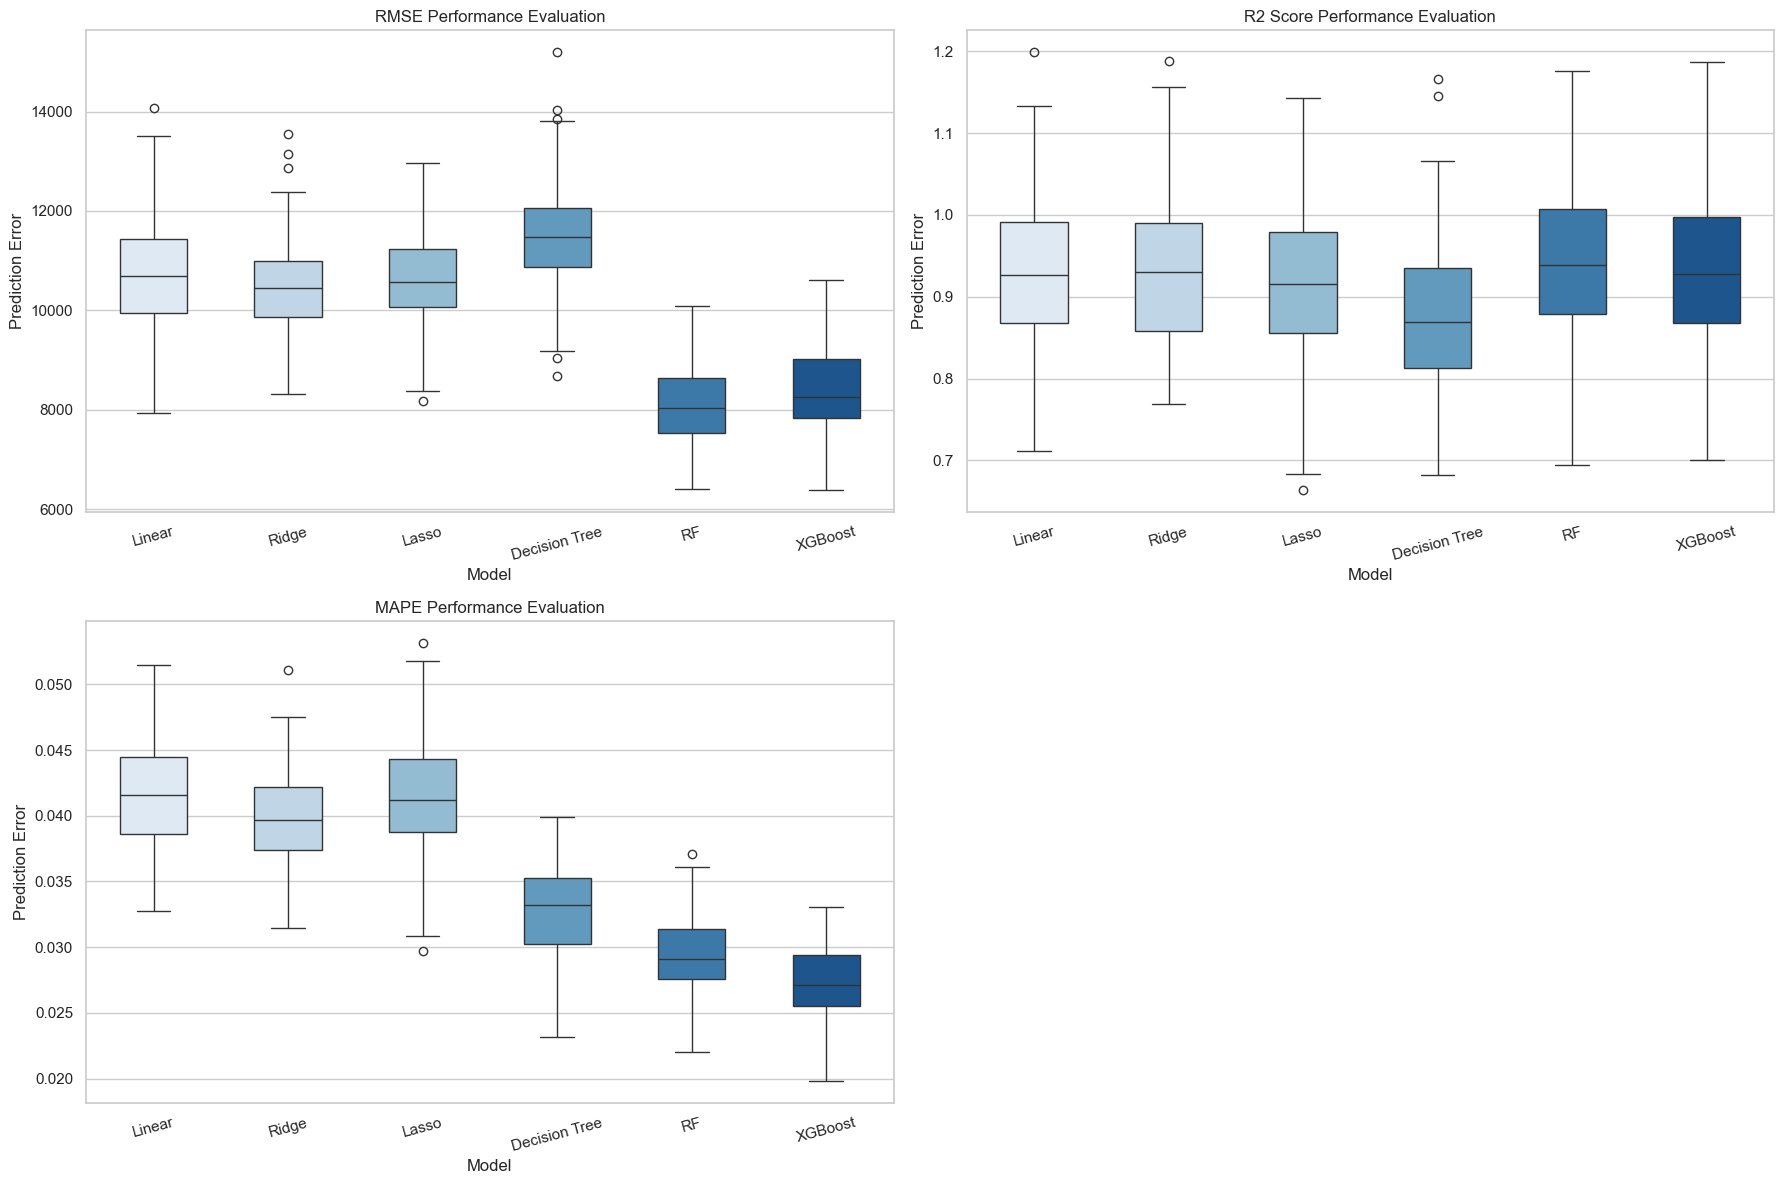

In [53]:
# Create the boxplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=False)

# RMSE
sns.boxplot(x='Model', y='Value', data=df[df['Metric'] == 'RMSE'], ax=axes[0, 0], palette="Blues", width=0.5)
axes[0, 0].set_title('RMSE Performance Evaluation')
axes[0, 0].set_ylabel('Prediction Error')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=15)

# R2 Score
sns.boxplot(x='Model', y='Value', data=df[df['Metric'] == 'R2 Score'], ax=axes[0, 1], palette="Blues", width=0.5)
axes[0, 1].set_title('R2 Score Performance Evaluation')
axes[0, 1].set_ylabel('Prediction Error')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=15)

# MAPE
sns.boxplot(x='Model', y='Value', data=df[df['Metric'] == 'MAPE'], ax=axes[1, 0], palette="Blues", width=0.5)
axes[1, 0].set_title('MAPE Performance Evaluation')
axes[1, 0].set_ylabel('Prediction Error')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=15)

# Hide the empty subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

#### Feature Importance

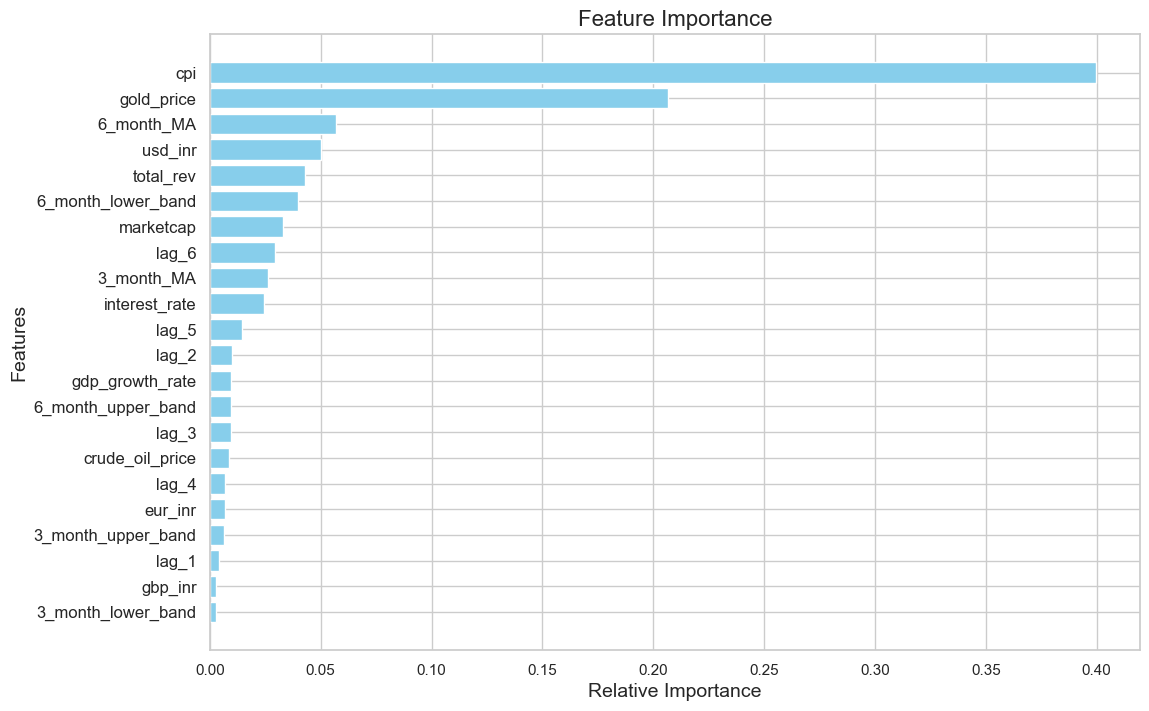

In [61]:
# 1. Feature Importance Plot
feature_importances = rf_reg.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importance', fontsize=16)
plt.barh(range(len(indices)), feature_importances[indices], align='center', color='skyblue')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=12)
plt.xlabel('Relative Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

#### PDP Plots

In [63]:
from sklearn.inspection import PartialDependenceDisplay
import scipy.stats as stats

In [68]:
# Convert scaled arrays back to DataFrame with original feature names
X_train_with_original_names = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_with_original_names = pd.DataFrame(X_test_scaled, columns=X.columns)

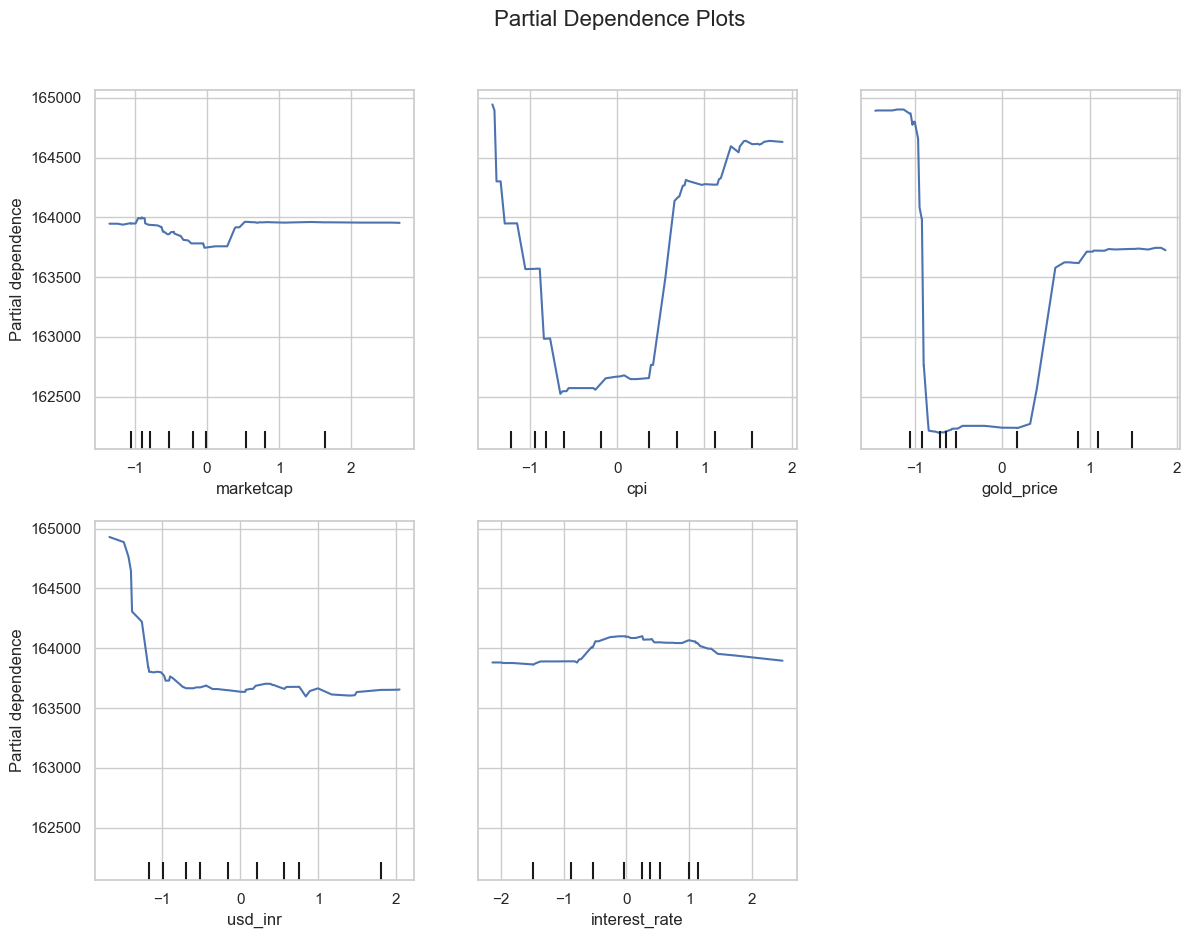

In [71]:
# 2. Partial Dependence Plots
features_to_plot = ['marketcap', 'cpi', 'gold_price', 'usd_inr', 'interest_rate']

fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(rf_reg, X_train_with_original_names, features_to_plot, ax=ax)
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plots', fontsize=16)
plt.show()


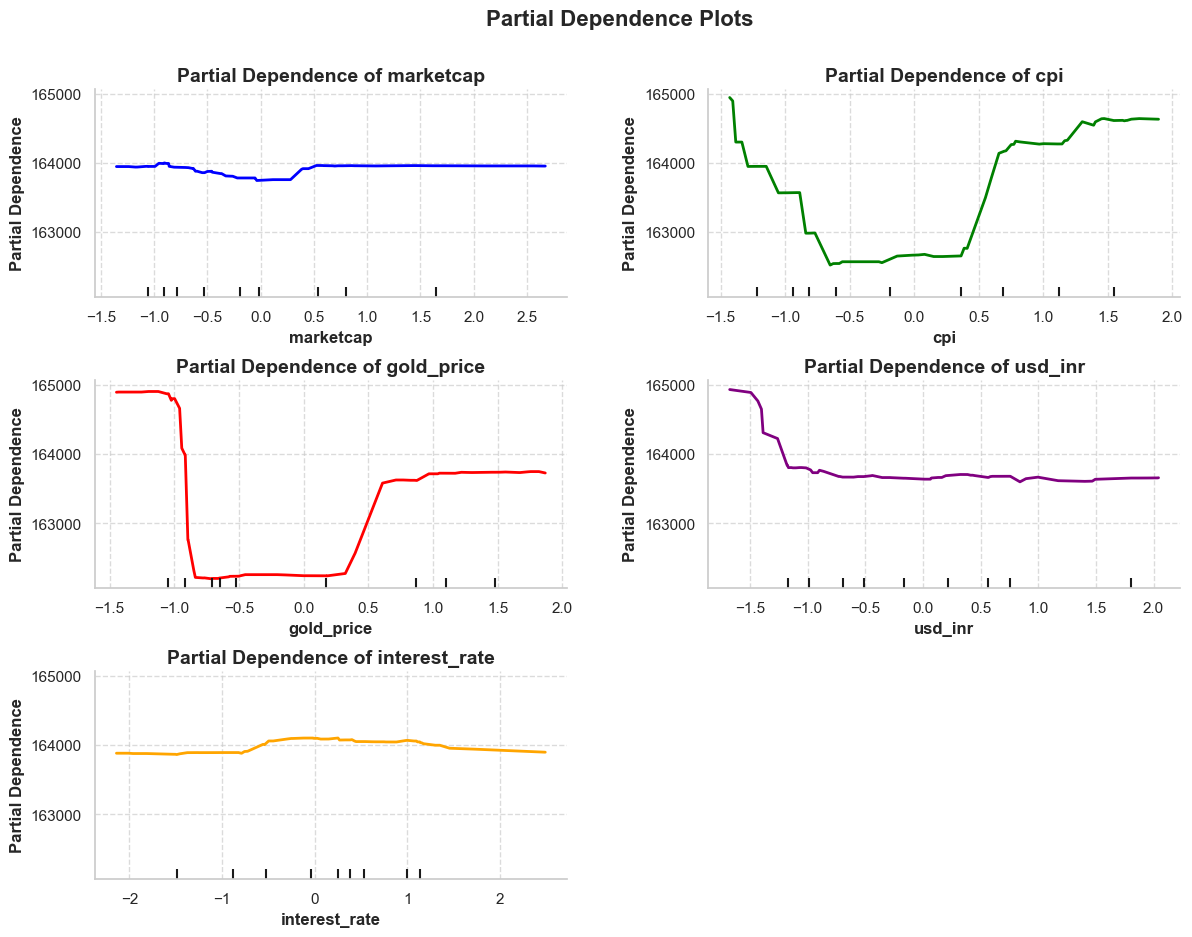

In [80]:
# 2. Partial Dependence Plots
features_to_plot = ['marketcap', 'cpi', 'gold_price', 'usd_inr', 'interest_rate']

# Calculate the number of rows and columns based on the number of features
n_features = len(features_to_plot)
n_cols = 2
n_rows = (n_features + 1) // n_cols

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 10))
ax = ax.flatten()

display = PartialDependenceDisplay.from_estimator(rf_reg, X_train_with_original_names, features_to_plot, ax=ax[:n_features])

# Customize the plots
colors = ['blue', 'green', 'red', 'purple', 'orange']
for i, (feature, color) in enumerate(zip(features_to_plot, colors)):
    for line in ax[i].get_lines():
        line.set_color(color)
        line.set_linewidth(2)
    ax[i].set_title(f'Partial Dependence of {feature}', fontsize=14, fontweight='bold')
    ax[i].set_xlabel(feature, fontsize=12, fontweight='bold')
    ax[i].set_ylabel('Partial Dependence', fontsize=12, fontweight='bold')
    ax[i].grid(True, linestyle='--', alpha=0.7)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

# Remove any unused subplots
for j in range(n_features, len(ax)):
    fig.delaxes(ax[j])

plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
plt.suptitle('Partial Dependence Plots', fontsize=16, fontweight='bold')
plt.show()


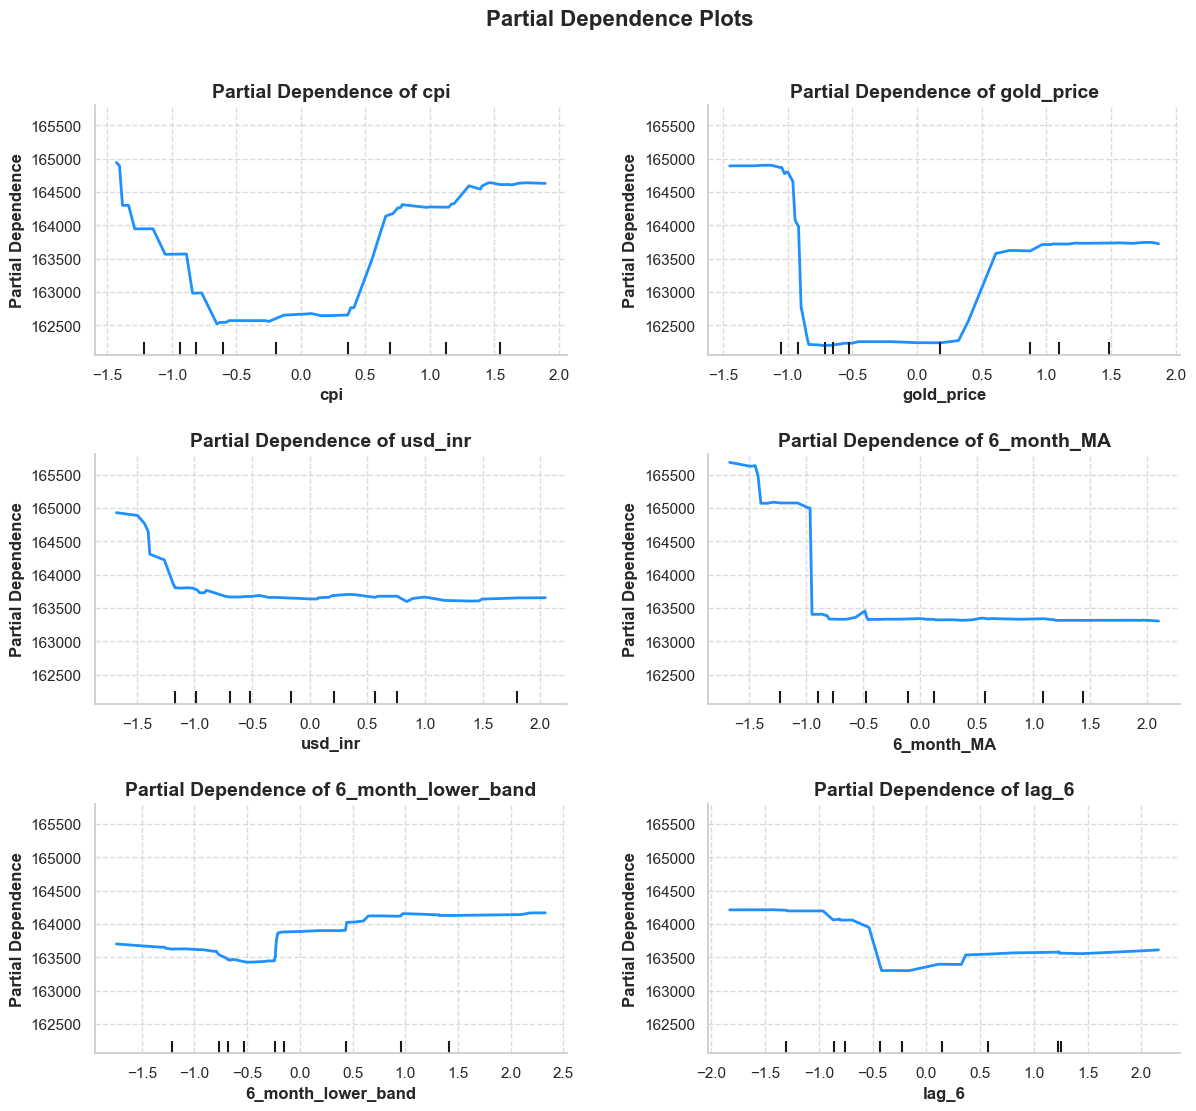

In [91]:
# 2. Partial Dependence Plots
# features_to_plot = ['marketcap', 'cpi', 'gold_price', 'usd_inr', 'interest_rate', '6_month_MA']
features_to_plot = ['cpi', 'gold_price', 'usd_inr', '6_month_MA', '6_month_lower_band', 'lag_6']

# Calculate the number of rows and columns based on the number of features
n_features = len(features_to_plot)
n_cols = 2
n_rows = (n_features + 1) // n_cols

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 12))
ax = ax.flatten()

display = PartialDependenceDisplay.from_estimator(rf_reg, X_train_with_original_names, features_to_plot, ax=ax[:n_features])

# Customize the plots
color = 'dodgerblue'
for i, feature in enumerate(features_to_plot):
    for line in ax[i].get_lines():
        line.set_color(color)
        line.set_linewidth(2)
    ax[i].set_title(f'Partial Dependence of {feature}', fontsize=14, fontweight='bold')
    ax[i].set_xlabel(feature, fontsize=12, fontweight='bold')
    ax[i].set_ylabel('Partial Dependence', fontsize=12, fontweight='bold')
    ax[i].grid(True, linestyle='--', alpha=0.7)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

# Remove any unused subplots
for j in range(n_features, len(ax)):
    fig.delaxes(ax[j])

plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
plt.suptitle('Partial Dependence Plots', fontsize=16, fontweight='bold')
plt.show()

# 'cpi', 'gold_price', 'usd_inr', '6_month_MA', '6_month_lower_band', 'lag_6'

#### Actual vs Predicted Plots

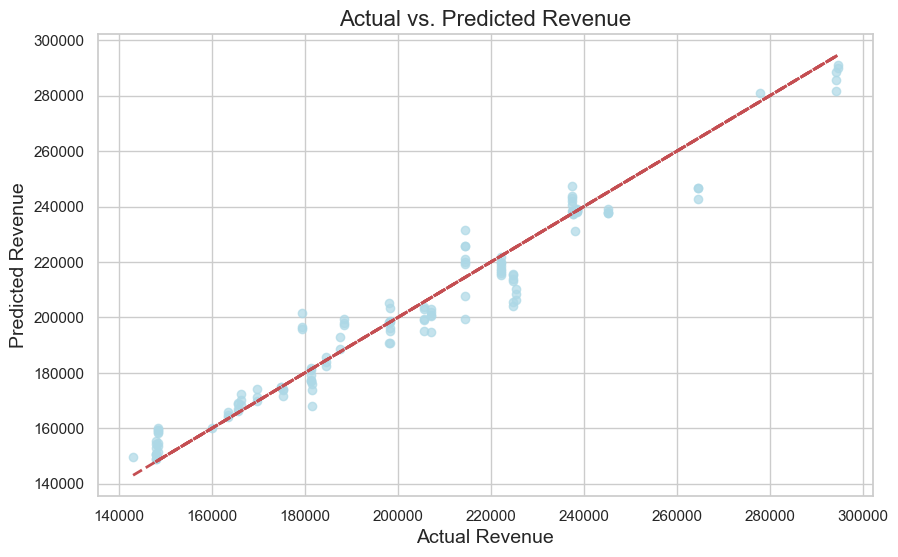

In [82]:
# 3. Actual vs Predicted Plot
y_test_pred_rf = rf_reg.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.7, color='lightblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue', fontsize=14)
plt.ylabel('Predicted Revenue', fontsize=14)
plt.title('Actual vs. Predicted Revenue', fontsize=16)
plt.show()

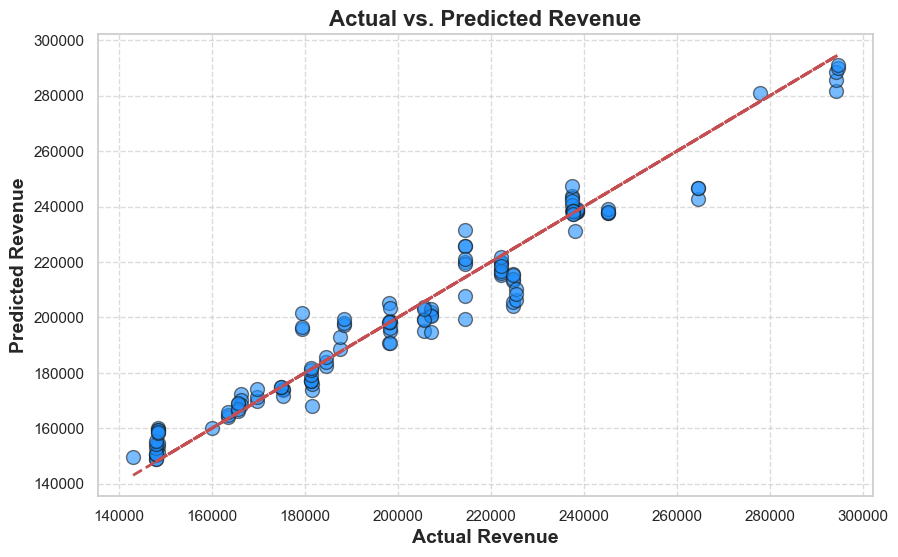

In [85]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.6, color='dodgerblue', edgecolor='k', s=100, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Actual Revenue', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Revenue', fontsize=14, fontweight='bold')
plt.title('Actual vs. Predicted Revenue', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend(fontsize=12)
plt.show()

#### Residual Plots

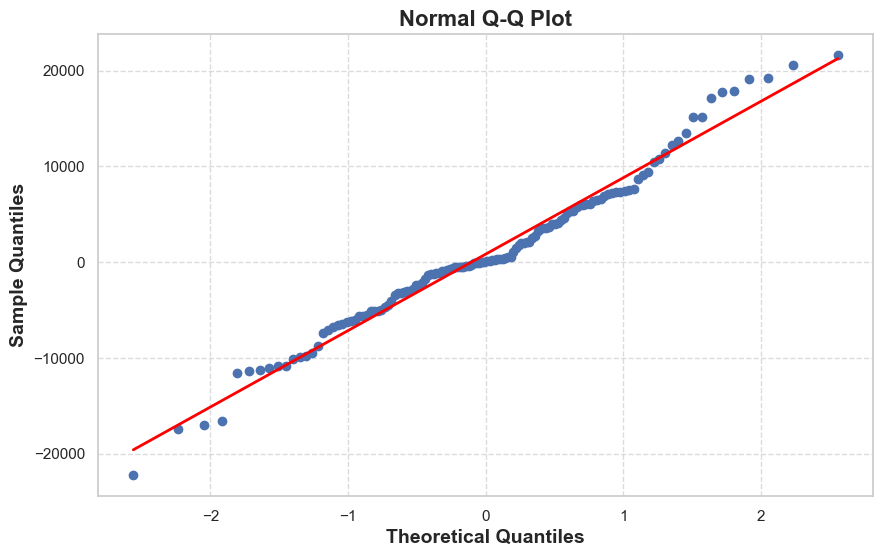

In [88]:
# Q-Q Plot for residuals

residuals = y_test - y_test_pred_rf
plt.figure(figsize=(10, 6))
stats.probplot(residuals.to_numpy().flatten(), dist="norm", plot=plt)
plt.title('Normal Q-Q Plot', fontsize=16, fontweight='bold')
plt.xlabel('Theoretical Quantiles', fontsize=14, fontweight='bold')
plt.ylabel('Sample Quantiles', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().get_lines()[1].set_color('red')
plt.gca().get_lines()[1].set_linewidth(2)
plt.show()
